# Test Run 10 Aggregate Generative Labels for Discriminative Modeling

This notebook continues from test run 9. Specifically, we did 2 things:

1. aggregate the generative labels for each train set doc, such that each word in a train doc will have its label as one of Background (BG), Purpose (PP), Mechanism (MN), Method (MT), and Finding (FD). 

2. Re-segment `train_segments` by clauses using `non_comma_matcher`, instead of sentences, which is a bug adopted from the `dev_segments` (who used `non_tilde_matcher`). In more detail, we modified `extract_and_display`, which is slightly different from earlier version.

3. Re-aggregate data into a word-level `.xlsx` file, where each row is a token in a document. It should have columns like `winningHighlight`, `paperID`, `globalPsn`,`content`. Punctuations does NOT have to be splitted from its token. The `xlsx` file will be used by the `make-tagging-data.ipynb` notebook in `BiLSTM_tagger/data` repository. 

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))
debug_mode=1 # if not in debug mode, please set debug_mode=0, find more info about debug mode in test run 9 maybe?
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os

### Section 1: Loading documents and train/dev/test segments. 

#### The following two celsl should load in 8014 papers if they haven't been loaded. 

In [2]:
# from snorkel import SnorkelSession
# from snorkel.parser import TSVDocPreprocessor
# session = SnorkelSession()

# # # Here, we just set how many documents we'll process for automatic testing- you can safely ignore this!
# n_docs = 9000 # this is the upper limit of number of docs
# doc_preprocessor = TSVDocPreprocessor('data/70kpaper_061418_cleaned_noBookLecture_10cscw_2k_order_preserving.tsv', encoding="utf-8",max_docs=n_docs)

# from snorkel.parser.spacy_parser import Spacy
# from snorkel.parser import CorpusParser


# # corpus_parser = CorpusParser(parser=Spacy())
# # %time corpus_parser.apply(doc_preprocessor, count=n_docs)


# from snorkel.models import Document, Sentence  # defined in context.py file

# print("Documents:", session.query(Document).count())
# print("Sentences:", session.query(Sentence).count())

In [3]:
from snorkel import SnorkelSession
from snorkel.parser.spacy_parser import Spacy
from snorkel.parser import CorpusParser
from snorkel.models import Document, Sentence

session = SnorkelSession()
print("Documents:", session.query(Document).count())
print("Sentences:", session.query(Sentence).count())

docs = session.query(Document).all()
sents = session.query(Sentence).all()  # get all sentences from snorkel.db
n_max_corpus=0
for sent in sents:
    n_max_corpus=max(n_max_corpus,len(sent.words))
print("The longest sentence has "+str(n_max_corpus)+" tokens.")

train_sents = set()
dev_sents   = set()
test_sents  = set()

train_doc_set=set()
dev_doc_set = set()
test_doc_set = set()
for i, doc in enumerate(docs):
    for s in doc.sentences:
        if doc.name[:7]=="2K_dev_":
            dev_sents.add(s)
            dev_doc_set.add(doc.name)
        elif doc.name[:8]=="2K_test_":
            test_sents.add(s)
            test_doc_set.add(doc.name)
        else:
            train_sents.add(s)
            train_doc_set.add(doc.name)
print("train_doc_set length",len(train_doc_set))
print("dev_doc_set length",len(dev_doc_set))
print("dev_sents length", len(dev_sents),"dev_doc_set size", len(dev_doc_set), "avg n_sent per doc","%.3f"%(float(len(dev_sents))/float(len(dev_doc_set))))
print("test_doc_set length",len(test_doc_set))
print("test_sents length", len(test_sents),"test_doc_set size", len(test_doc_set), "avg n_sent per doc","%.3f"%(float(len(test_sents))/float(len(test_doc_set))))

Documents: 8014
Sentences: 24281
The longest sentence has 563 tokens.
train_doc_set length 5560
dev_doc_set length 383
dev_sents length 835 dev_doc_set size 383 avg n_sent per doc 2.180
test_doc_set length 2071
test_sents length 4566 test_doc_set size 2071 avg n_sent per doc 2.205


In [4]:
from snorkel.models import candidate_subclass
from snorkel.candidates import Ngrams, CandidateExtractor
from snorkel.matchers import *

from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))
    
### NOTE: this extract_and_display is different from earlier test run notebook's version, whrere selected_split=0 will only extract train_segments. 
def extract_and_display(matcher,candidate_class,candidate_class_name,train_breakdown_map=None,dev_doc_breakdown_map=None,selected_split=0,is_print=True):  # split over train/dev/test but returns only train set
    for (i, sents) in ([(0,train_sents)] if selected_split==0 else ([(2,test_sents)] if selected_split==2 else [(1,dev_sents)])):
        %time matcher.apply(sents, split=i)
        printmd("**Split "+str(i)+" - number of candidates extracted: "+str(session.query(candidate_class).filter(candidate_class.split == i).count())+"**\n\n")
    
    train_cands = session.query(candidate_class).filter(candidate_class.split == selected_split).all()
    if is_print:
        for i in range(min(4,len(train_cands))): # to print at most 4 cands 
            printmd("**"+str(i)+"/"+str(len(train_cands))+" Candidate/Span:**\t`"+str(train_cands[i])+"`")
            printmd("**Its parent Sentence's text:**\t"+str(train_cands[i].get_parent().text))
            printmd("**Its parent Document's text:**\t"+str(train_cands[i].get_parent().get_parent().__dict__))
            print() 
        
    for cand in train_cands:
        doc_name=cand.get_parent().get_parent().name
        if doc_name not in train_breakdown_map:
            train_breakdown_map[doc_name]=dict()
        if candidate_class_name not in train_breakdown_map[doc_name]:
            train_breakdown_map[doc_name][candidate_class_name]=[]
        train_breakdown_map[doc_name][candidate_class_name]+=[cand]
        
    dev_cands = session.query(candidate_class).filter(candidate_class.split == 1).all()
    
    for cand in dev_cands:
        doc_name=cand.get_parent().get_parent().name
        if doc_name not in dev_doc_breakdown_map:
            dev_doc_breakdown_map[doc_name]=dict()
        if candidate_class_name not in dev_doc_breakdown_map[doc_name]:
            dev_doc_breakdown_map[doc_name][candidate_class_name]=[]
        dev_doc_breakdown_map[doc_name][candidate_class_name]+=[cand]
    test_cands=session.query(candidate_class).filter(candidate_class.split==2).all()
    
    return train_cands,dev_cands,test_cands

Segment = candidate_subclass('Segment', ['segment_cue'])
ngrams = Ngrams(n_max=n_max_corpus) 
non_tilde_matcher=DictionaryMatch(d=['~'],longest_match_only=True,reverse=True)  
non_tilde_segment_extractor=CandidateExtractor(Segment, [ngrams], [non_tilde_matcher])

non_comma_matcher=DictionaryMatch(d=[','],longest_match_only=True,reverse=True)  
non_comma_segment_extractor=CandidateExtractor(Segment, [ngrams], [non_comma_matcher])

train_doc_breakdown_map=dict()
dev_doc_breakdown_map=dict()

# train_segments,dev_segments,test_segments=extract_and_display(non_comma_segment_extractor,Segment,"Segment",train_breakdown_map=train_doc_breakdown_map,dev_doc_breakdown_map=dev_doc_breakdown_map,is_print=False)
train_segments=session.query(Segment).filter(Segment.split == 0).all()
print("len(train_segments)",len(train_segments))
dev_segments=session.query(Segment).filter(Segment.split == 1).all()
print("len(dev_segments)",len(dev_segments))
test_segments=session.query(Segment).filter(Segment.split == 2).all()
print("len(test_segments)",len(test_segments))

len(train_segments) 35228
len(dev_segments) 3834
len(test_segments) 19993


### Section 2: Create generative labels for Purpose on train set

Any LFs for other aspects will be grouped into `neg_for_purpose_LFs`

In [5]:
from snorkel.lf_helpers import *
from snorkel.annotations import LabelAnnotator
from LF.util_purpose_default import common_LFs,purpose_LFs,neg_for_purpose_LFs   # neg_LFs are reverse LFs for Background, Mechanism, Method, and Finding

print("common_LFs",len(common_LFs))
print("purpose_LFs",len(purpose_LFs))
print("neg_for_purpose_LFs",len(neg_for_purpose_LFs)) # 39 mechanism, 35 background, 11 methods, 24 findings

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


common_LFs 8
purpose_LFs 74
neg_for_purpose_LFs 111


We also report <b>Total Coverage</b>: Coverage that corrected from Overlaps and Conflicts, essentially # candidates that are labelled by at least one LF / # total candidates. We also did a quick sanity check to ensure this number is calculated correctly, see [`data/calculate_total_coverage_toy_test_for_test_run_8.xlsx`](data/calculate_total_coverage_toy_test_for_test_run_8.xlsx).

In [6]:
# from snorkel.learning import GenerativeModel
# np.random.seed(1701)
# labeler = LabelAnnotator(lfs=common_LFs+purpose_LFs+neg_for_purpose_LFs)
# import datetime
# print(datetime.datetime.now())
# %time L_train = labeler.apply(split=0)
# printmd("**Total non_overlapping_coverage on L_train (percentage of labelled over all)**  "+str(L_train.non_overlapping_coverage()))
# print(datetime.datetime.now())

# gen_model = GenerativeModel(lf_propensity=True)
# gen_model.train(L_train, epochs=100, decay=0.95, step_size=0.1/L_train.shape[0], reg_param=0.0,verbose=False) # try step_size = 1/ next time? 
# print("finished")
# import datetime
# print(datetime.datetime.now())
# print("Finished training generative model, now checking performance against development set labels...")

In [7]:
# print("Calculating marginals!")
# train_marginals = gen_model.marginals(L_train)  # the marginal probability of each candidate being True
# print("Marginals finished")
# import matplotlib.pyplot as plt
# plt.hist(train_marginals, bins=50)
# plt.grid()
# plt.show()

In [8]:
# from util import get_candidate_text
# train_marginals_list_purpose=list(train_marginals)
# print("first score in train_marginals",train_marginals_list_purpose[0])

### Section 3: Repeat Section 2 for all other 4 aspects! 

In [9]:
# from LF.util_background_default import background_LFs
# from LF.util_purpose_default import neg_for_background_LFs  

# print("background_LFs",len(background_LFs))
# print("neg_for_background_LFs",len(neg_for_background_LFs)) # 39 mechanism, 35 background, 24 findings

# from snorkel.learning import GenerativeModel
# np.random.seed(1701)
# labeler = LabelAnnotator(lfs=background_LFs+neg_for_background_LFs)
# %time L_train = labeler.apply(split=0)
# print(L_train.shape)
# printmd("**Total non_overlapping_coverage on L_train (percentage of labelled over all)**  "+str(L_train.non_overlapping_coverage()))
# import datetime
# print(datetime.datetime.now())

# gen_model = GenerativeModel(lf_propensity=True)
# gen_model.train(L_train, epochs=100, decay=0.95, step_size=0.1/L_train.shape[0], reg_param=0.0,verbose=False) # try step_size = 1/ next time? 
# print("training finished ")
# import datetime
# print(datetime.datetime.now())
# print("Finished training generative model, now checking performance against development set labels...")
# print("Calculating marginals!")
# train_marginals = gen_model.marginals(L_train)  # the marginal probability of each candidate being True
# print("Marginals finished")
# import matplotlib.pyplot as plt
# plt.hist(train_marginals, bins=50)
# plt.grid()
# plt.show()

# from util import get_candidate_text
# train_marginals_list_background=list(train_marginals)
# print("first score in train_marginals",train_marginals_list_purpose[0])


pos_LFs 82
neg_LFs 111
2018-09-24 21:13:57.903641
cids_count 35228
key_group 0
Clearing existing...
Running UDF...
[========================================] 100%

2018-09-24 21:21:51.307394
<class 'snorkel.annotations.csr_LabelMatrix'>
(35228, 193)


**Total non_overlapping_coverage on L_train (percentage of labelled over all)**  1.0

2018-09-24 21:21:51.331297
Inferred cardinality: 2
training finished 
2018-09-24 21:44:09.425389
Finished training generative model, now checking performance against development set labels...
Calculating marginals!
Marginals finished


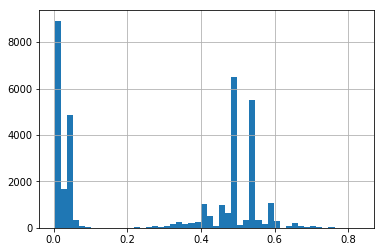

first score in train_marginals 0.013513146224873877


In [10]:
from snorkel.learning import GenerativeModel
from util import get_candidate_text
import matplotlib.pyplot as plt
import datetime

def get_train_marginals(pos_LFs,neg_LFs,step_size_nominator=0.1,epochs=100,threads=1):
    L_train=None
    labeler=None
    gen_model=None
    print("pos_LFs",len(pos_LFs))
    print("neg_LFs",len(neg_LFs)) # 39 mechanism, 35 background, 24 findings
    np.random.seed(1701)
    labeler = LabelAnnotator(lfs=pos_LFs+neg_LFs)
    print(datetime.datetime.now())
    L_train = labeler.apply(split=0)
    print(datetime.datetime.now())
    print(type(L_train))
    print(L_train.shape)
    printmd("**Total non_overlapping_coverage on L_train (percentage of labelled over all)**  "+str(L_train.non_overlapping_coverage()))
    print(datetime.datetime.now())
    gen_model = GenerativeModel(lf_propensity=True)
    gen_model.train(L_train, epochs=100, decay=0.95, step_size=0.1/L_train.shape[0], reg_param=0.0,verbose=False,threads=threads) # try step_size = 1/ next time? 
    print("training finished ")
    print(datetime.datetime.now())
    print("Finished training generative model, now checking performance against development set labels...")
    print("Calculating marginals!")
    train_marginals = gen_model.marginals(L_train)  # the marginal probability of each candidate being True
    print("Marginals finished")
    plt.hist(train_marginals, bins=50)
    plt.grid()
    plt.show()
    train_marginals_list=list(train_marginals)
    print("first score in train_marginals",train_marginals_list[0])
    return train_marginals_list

train_marginals_list_purpose=get_train_marginals(common_LFs+purpose_LFs,neg_for_purpose_LFs,threads=10)

pos_LFs 35
neg_LFs 158
2018-09-24 21:44:30.307704
cids_count 35228
key_group 0
Clearing existing...
Running UDF...
[========================================] 100%

2018-09-24 21:52:13.185926
<class 'snorkel.annotations.csr_LabelMatrix'>
(35228, 193)


**Total non_overlapping_coverage on L_train (percentage of labelled over all)**  1.0

2018-09-24 21:52:13.215582
Inferred cardinality: 2
training finished 
2018-09-24 22:15:41.135964
Finished training generative model, now checking performance against development set labels...
Calculating marginals!
Marginals finished


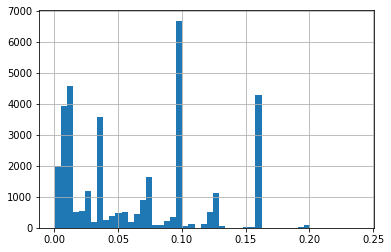

first score in train_marginals 0.012249156582319384


In [11]:
from LF.util_background_default import background_LFs
from LF.util_purpose_default import neg_for_background_LFs 

train_marginals_list_background=get_train_marginals(background_LFs,neg_for_background_LFs,threads=10)

pos_LFs 39
neg_LFs 155
cids_count 35228
key_group 0
Clearing existing...
Running UDF...
[========================================] 100%

<class 'snorkel.annotations.csr_LabelMatrix'>
(35228, 193)


**Total non_overlapping_coverage on L_train (percentage of labelled over all)**  1.0

2018-09-24 12:54:20.602394
Inferred cardinality: 2
training finished 
2018-09-24 13:29:36.164808
Finished training generative model, now checking performance against development set labels...
Calculating marginals!
Marginals finished


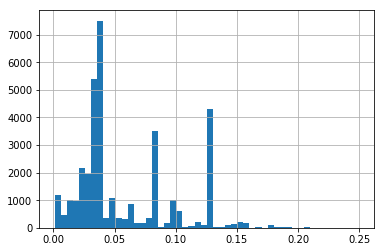

first score in train_marginals 0.031319676938777206


In [5]:
from LF.util_mechanism_default import mechanism_LFs
from LF.util_purpose_default import neg_for_mechanism_LFs 

train_marginals_list_mechanism=get_train_marginals(mechanism_LFs,neg_for_mechanism_LFs)

pos_LFs 36
neg_LFs 158
cids_count 35228
key_group 0
Clearing existing...
Running UDF...
[========================================] 100%

<class 'snorkel.annotations.csr_LabelMatrix'>
(35228, 193)


**Total non_overlapping_coverage on L_train (percentage of labelled over all)**  1.0

2018-09-24 13:36:51.874241
Inferred cardinality: 2
training finished 
2018-09-24 14:16:53.384274
Finished training generative model, now checking performance against development set labels...
Calculating marginals!
Marginals finished


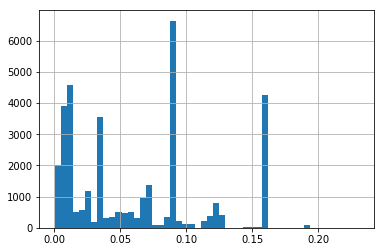

first score in train_marginals 0.011792412377615672


In [6]:
from LF.util_background_default import background_LFs
from LF.util_purpose_default import neg_for_background_LFs

train_marginals_list_background=get_train_marginals(background_LFs,neg_for_background_LFs)

pos_LFs 12
neg_LFs 182
cids_count 35228
key_group 0
Clearing existing...
Running UDF...
[========================================] 100%

<class 'snorkel.annotations.csr_LabelMatrix'>
(35228, 193)


**Total non_overlapping_coverage on L_train (percentage of labelled over all)**  1.0

2018-09-24 14:25:43.801226
Inferred cardinality: 2
training finished 
2018-09-24 15:03:56.167267
Finished training generative model, now checking performance against development set labels...
Calculating marginals!
Marginals finished


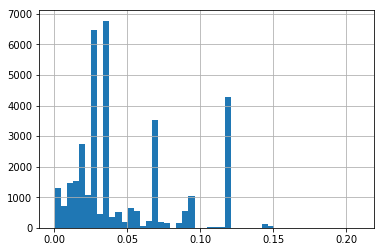

first score in train_marginals 0.02585725772975347


In [7]:
from LF.util_method_default import method_LFs
from LF.util_purpose_default import neg_for_method_LFs

train_marginals_list_method=get_train_marginals(method_LFs,neg_for_method_LFs)

pos_LFs 25
neg_LFs 169
cids_count 35228
key_group 0
Clearing existing...
Running UDF...
[========================================] 100%

<class 'snorkel.annotations.csr_LabelMatrix'>
(35228, 193)


**Total non_overlapping_coverage on L_train (percentage of labelled over all)**  1.0

2018-09-24 15:11:30.374695
Inferred cardinality: 2
training finished 
2018-09-24 15:51:27.777310
Finished training generative model, now checking performance against development set labels...
Calculating marginals!
Marginals finished


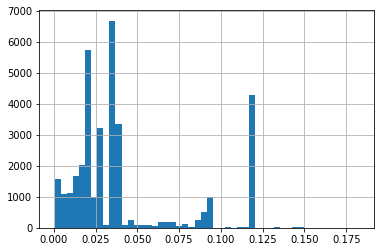

first score in train_marginals 0.020488173154502923


In [8]:
from LF.util_finding_default import finding_LFs
from LF.util_purpose_default import neg_for_finding_LFs

train_marginals_list_finding=get_train_marginals(finding_LFs,neg_for_finding_LFs)

### Section 4: calculate winning aspects, and check if the number is (nearly) consistent with 2K ground-truth (note down here too!!)

In [5]:
import pickle
dirpath="data/train_marginals_list"

# pickle.dump(train_marginals_list_mechanism,open(os.path.join(dirpath,"train_marginals_list_mechanism"),"wb"))
# pickle.dump(train_marginals_list_method,open(os.path.join(dirpath,"train_marginals_list_method"),"wb"))
# pickle.dump(train_marginals_list_finding,open(os.path.join(dirpath,"train_marginals_list_finding"),"wb"))

# pickle.dump(train_marginals_list_background,open(os.path.join(dirpath,"train_marginals_list_background"),"wb"))
# pickle.dump(train_marginals_list_purpose,open(os.path.join(dirpath,"train_marginals_list_purpose"),"wb"))
# train_marginals_list_background

# train_marginals_list_background
# train_marginals_list_purpose


train_marginals_list_mechanism=pickle.load(open(os.path.join(dirpath,"train_marginals_list_mechanism"),"rb"))
train_marginals_list_method=pickle.load(open(os.path.join(dirpath,"train_marginals_list_method"),"rb"))
train_marginals_list_finding=pickle.load(open(os.path.join(dirpath,"train_marginals_list_finding"),"rb"))
train_marginals_list_purpose=pickle.load(open(os.path.join(dirpath,"train_marginals_list_purpose"),"rb"))
train_marginals_list_background=pickle.load(open(os.path.join(dirpath,"train_marginals_list_background"),"rb"))


In [32]:
segid=2800
print(train_marginals_list_background[segid])
print(train_marginals_list_purpose[segid])
print(train_marginals_list_mechanism[segid])
print(train_marginals_list_method[segid])
print(train_marginals_list_finding[segid])


import numpy as np
BG=np.asarray(train_marginals_list_background)
PP=np.asarray(train_marginals_list_purpose)
MN=np.asarray(train_marginals_list_mechanism)
MT=np.asarray(train_marginals_list_method)
FD=np.asarray(train_marginals_list_finding)

total=np.asarray([BG,PP,MN,MT,FD])
total=np.transpose(total)
print(total.shape)

winHighlight=total.argmax(axis=1)
print((winHighlight==0).sum())
print((winHighlight==1).sum())
print((winHighlight==2).sum())
print((winHighlight==3).sum())
print((winHighlight==4).sum())

print(winHighlight[3])

def softmax(x,axis=1):
    """Compute softmax values for each sets of scores in x."""
    return np.exp(x) / np.sum(np.exp(x), axis=axis).reshape((-1, 1))


print("generative binary labels for all 5 aspects\n",total,"\n")
softmax_total=softmax(total)
print("softmax over dim=1\n",softmax_total,"\n")
padded_softmax_total=np.pad(softmax_total,((0,0),(0,1)),'constant',constant_values=[0])
print("pad with an all-zero NULL label column\n",padded_softmax_total)







0.02748687774166179
0.049882750720828185
0.0641458913194704
0.05502352934507879
0.028867966237666118
(35228, 5)
3
22170
12239
479
337
1
generative binary labels for all 5 aspects
 [[0.01224916 0.01351315 0.03131968 0.02585726 0.02048817]
 [0.09621319 0.48367409 0.04030548 0.03670227 0.03633894]
 [0.09621319 0.48367409 0.04030548 0.03670227 0.03633894]
 ...
 [0.0502089  0.3314246  0.05772175 0.01872469 0.01850078]
 [0.16179487 0.53144704 0.12802022 0.11998229 0.11899611]
 [0.09621319 0.48367409 0.04030548 0.03670227 0.03633894]] 

softmax over dim=1
 [[0.19831462 0.19856545 0.20213288 0.20103176 0.19995529]
 [0.18857357 0.27781326 0.17832015 0.17767878 0.17761424]
 [0.18857357 0.27781326 0.17832015 0.17767878 0.17761424]
 ...
 [0.18975058 0.25137006 0.19118152 0.1838695  0.18382834]
 [0.18757594 0.27146574 0.18134642 0.17989461 0.17971729]
 [0.18857357 0.27781326 0.17832015 0.17767878 0.17761424]] 

pad with an all-zero NULL label column
 [[0.19831462 0.19856545 0.20213288 0.20103176 0.

In [7]:
print(train_segments[0])
print(train_segments[1])
print(train_segments[3])
print(train_segments[4])


Segment(Span("b'We have integrated these techniques in the NAW qstm [IO].\n'", sentence=14361, chars=[0,57], words=[0,13]))
Segment(Span("b'cello'", sentence=19479, chars=[96,100], words=[15,15]))
Segment(Span("b'percussion'", sentence=19479, chars=[103,112], words=[17,17]))
Segment(Span("b'and dancer.'", sentence=19479, chars=[115,125], words=[19,21]))


### Section 4: writing generative noisy labels in setting 1 (S1)

In [33]:
from collections import defaultdict
from util import get_candidate_text
import pandas as pd

# initialize some variables
# df = pd.DataFrame([], columns=['winningHighlight', 'paperID', 'globalPsn','content'])    
aggregated_doc=defaultdict(lambda:[])
aggregated_sent=defaultdict(lambda:[])
aspects_list=["Background","Purpose","Mechanism","Method","Findings"]

for idx,train_segment in enumerate(train_segments):
    
    sent_id=train_segment.get_parent().id    
    winningHighlight=winHighlight[idx]
    aggregated_sent[sent_id]+=[(train_segment.segment_cue.char_start,train_segment.segment_cue.char_end,get_candidate_text(train_segment),winningHighlight)]
    
    doc_id=train_segment.get_parent().get_parent().name
    if doc_id not in aggregated_doc:
        aggregated_doc[doc_id]=train_segment.get_parent().get_parent().sentences
        

df_list=[]      
for doc_id in aggregated_doc:
    globalPsn=1
    for sent in aggregated_doc[doc_id]:
        sent_id=sent.id
        if sent_id not in aggregated_sent:
            raise ValueError('we have no info about this sent'+str(sent))
        aggregated_sent[sent_id]=sorted(aggregated_sent[sent_id], key=lambda x: x[0])
        for idx,pair in enumerate(aggregated_sent[sent_id]):
            text=pair[2]
#             if "qstm" in text:
#                 print(text)
#                 print(text.split())
            for idx2,token in enumerate(text.split()):
                
                # insert a row into df
#                 df.loc[-1] = [pair[3],doc_id,globalPsn,token]
#                 df.index=df.index+1
                if len(token.strip())==0:
                    continue
                df_list+=[[pair[3],doc_id,globalPsn,token.strip(".")]]
                globalPsn+=1
            if idx!=len(aggregated_sent[sent_id])-1:
                df_list+=[[pair[3],doc_id,globalPsn,","]]
            else:
                df_list+=[[pair[3],doc_id,globalPsn,"."]]
            globalPsn+=1
                

df=pd.DataFrame(df_list,columns=['winningHighlight', 'paperID', 'globalPsn','content'])

df.to_csv(open("data/annotations_train_5560_word-level_s1.csv","w"))


### Section 5: writing generative noisy labels in setting 2 (S2)

In [34]:
from collections import defaultdict
from util import get_candidate_text
import pandas as pd

# initialize some variables
# df = pd.DataFrame([], columns=['winningHighlight', 'paperID', 'globalPsn','content'])    
aggregated_doc=defaultdict(lambda:[])
aggregated_sent=defaultdict(lambda:[])
aspects_list=["Background","Purpose","Mechanism","Method","Findings"]

for idx,train_segment in enumerate(train_segments):
    
    sent_id=train_segment.get_parent().id    
    winningHighlight=list(padded_softmax_total[idx])
    aggregated_sent[sent_id]+=[(train_segment.segment_cue.char_start,train_segment.segment_cue.char_end,get_candidate_text(train_segment),winningHighlight)]
    
    doc_id=train_segment.get_parent().get_parent().name
    if doc_id not in aggregated_doc:
        aggregated_doc[doc_id]=train_segment.get_parent().get_parent().sentences
        

df_list=[]      
for doc_id in aggregated_doc:
    globalPsn=1
    for sent in aggregated_doc[doc_id]:
        sent_id=sent.id
        if sent_id not in aggregated_sent:
            raise ValueError('we have no info about this sent'+str(sent))
        aggregated_sent[sent_id]=sorted(aggregated_sent[sent_id], key=lambda x: x[0])
        for idx,pair in enumerate(aggregated_sent[sent_id]):
            text=pair[2]
#             if "qstm" in text:
#                 print(text)
#                 print(text.split())
            for idx2,token in enumerate(text.split()):
                
                # insert a row into df
#                 df.loc[-1] = [pair[3],doc_id,globalPsn,token]
#                 df.index=df.index+1
                if len(token.strip())==0:
                    continue
                df_list+=[[pair[3],doc_id,globalPsn,token.strip(".")]]
                globalPsn+=1
            if idx!=len(aggregated_sent[sent_id])-1:
                df_list+=[[pair[3],doc_id,globalPsn,","]]
            else:
                df_list+=[[pair[3],doc_id,globalPsn,"."]]
            globalPsn+=1
                

df=pd.DataFrame(df_list,columns=['winningHighlight', 'paperID', 'globalPsn','content'])

df.to_csv(open("data/annotations_train_5560_word-level_s2.csv","w"))

In [14]:
docid=1
print("clause\t",train_segments[docid],"\n")
print("sent id\t",train_segments[docid].get_parent().id,"\n")
print("sentence\t",train_segments[docid].get_parent(),"\n")
print("sentence_dict\t",train_segments[docid].get_parent().__dict__,"\n")
print("all sentences in the doc\t",train_segments[docid].get_parent().get_parent().sentences,"\n")
print("this sentence pos in doc\t",train_segments[docid].get_parent().get_parent().sentences.index(train_segments[docid].get_parent()),"\n")
# print(docs[1].sentences)
print("doc name\t", train_segments[docid].get_parent().get_parent().name)

clause	 Segment(Span("b'cello'", sentence=19479, chars=[96,100], words=[15,15])) 

sent id	 19479 

sentence	 Sentence(Document 58cca85cc50f90cdd388252e,0,b'Abstract.\xe2\x80\x9cThe Watercourse Way\xe2\x80\x9d is a mostly-music interactive multimedia performance for violin, cello, percussion, and dancer.') 

sentence_dict	 {'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x1165ea048>, 'stable_id': '58cca85cc50f90cdd388252e::sentence:0:126', 'dep_parents': [3, 3, 5, 3, 0, 12, 9, 9, 12, 12, 12, 5, 12, 13, 14, 14, 16, 16, 18, 18, 18, 5], 'pos_tags': ['DT', 'NNP', 'NNP', '-RRB-', 'VBZ', 'DT', 'RB', 'HYPH', 'NN', 'JJ', 'NN', 'NN', 'IN', 'NN', ',', 'NN', ',', 'NN', ',', 'CC', 'NN', '.'], 'abs_char_offsets': [0, 14, 26, 29, 31, 34, 36, 42, 43, 49, 61, 72, 84, 88, 94, 96, 101, 103, 113, 115, 119, 125], 'entity_cids': ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'], 'char_offsets': [0, 14, 26, 29, 31, 34, 36, 42,